In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
import seaborn as sns
sns.despine()

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import merge
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers

import theano
theano.config.compute_test_value = "ignore"
%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv('ts.csv')
data.head()

,DATE,IN_FOR,OUT_FOR,IN_KZT,OUT_KZT
0,1/1/2016,0.0,122953.0,1899647.0,1584705.0
1,1/2/2016,2942.0,115059.0,2706416.0,2315761.0
2,1/3/2016,263.0,147905.0,3548855.0,2971268.0
3,1/4/2016,13533594.0,9363025.0,23528654.0,11716898.0
4,1/5/2016,36769881.0,32769452.0,37289979.0,22565273.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 5 columns):
DATE       731 non-null object
IN_FOR     731 non-null float64
OUT_FOR    731 non-null float64
IN_KZT     731 non-null float64
OUT_KZT    731 non-null float64
dtypes: float64(4), object(1)
memory usage: 28.6+ KB


In [4]:
def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b
 
def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


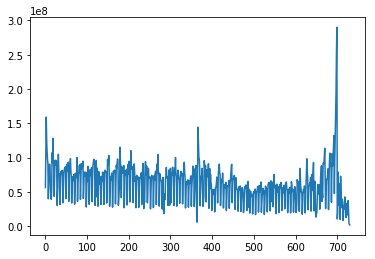

list index out of range


In [5]:
data0 = data[::-1]
data1 = data0.ix[:, 'IN_KZT'].tolist()

# Uncomment below to use price change time series
# data1 = data0.ix[:, 'IN_FOR'].pct_change().dropna().tolist()

plt.plot(data1)
plt.show()

WINDOW = 30
EMB_SIZE = 1
STEP = 1
FORECAST = 5

# Straightforward way for creating time windows
X, Y = [], []
for i in range(0, len(data1), STEP): 
    try:
        x_i = data1[i:i+WINDOW]
        y_i = data1[i+WINDOW+FORECAST]  

        last_close = x_i[WINDOW-1]
        next_close = y_i

        if last_close < next_close:
            y_i = [1, 0]
        else:
            y_i = [0, 1] 

    except Exception as e:
        print(e)
        break

    X.append(x_i)
    Y.append(y_i)

X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X] # comment it to remove normalization
X, Y = np.array(X), np.array(Y)

X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

In [6]:
model = Sequential()
model.add(Dense(64, input_dim=30,
                activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dropout(0.35))
model.add(Dense(16,
                activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(2))
model.add(Activation('linear'))

opt = Nadam(lr=0.001)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="in_kzt.hdf5", verbose=1, save_best_only=True)
model.compile(optimizer=opt, 
              loss='mean_squared_error',
              metrics=['acc'])

In [7]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 90, 
          batch_size = 128, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 626 samples, validate on 70 samples
Epoch 1/90
626/626 [==============================] - 1s 1ms/step - loss: 78.4035 - acc: 0.5383 - val_loss: 40.3371 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 40.33710, saving model to in_kzt.hdf5
Epoch 2/90
626/626 [==============================] - 0s 32us/step - loss: 71.3779 - acc: 0.5735 - val_loss: 37.9143 - val_acc: 0.5286

Epoch 00002: val_loss improved from 40.33710 to 37.91430, saving model to in_kzt.hdf5
Epoch 3/90
626/626 [==============================] - 0s 31us/step - loss: 65.3692 - acc: 0.5655 - val_loss: 35.4751 - val_acc: 0.5429

Epoch 00003: val_loss improved from 37.91430 to 35.47511, saving model to in_kzt.hdf5
Epoch 4/90
626/626 [==============================] - 0s 57us/step - loss: 60.1096 - acc: 0.5447 - val_loss: 33.1901 - val_acc: 0.5429

Epoch 00004: val_loss improved from 35.47511 to 33.19009, saving model to in_kzt.hdf5
Epoch 5/90
626/626 [==============================] - 0s 43us/step - loss

Epoch 38/90
626/626 [==============================] - 0s 44us/step - loss: 9.6731 - acc: 0.6486 - val_loss: 6.9727 - val_acc: 0.6000

Epoch 00038: val_loss improved from 7.22697 to 6.97273, saving model to in_kzt.hdf5
Epoch 39/90
626/626 [==============================] - 0s 55us/step - loss: 9.4318 - acc: 0.6166 - val_loss: 6.7277 - val_acc: 0.6000

Epoch 00039: val_loss improved from 6.97273 to 6.72771, saving model to in_kzt.hdf5
Epoch 40/90
626/626 [==============================] - 0s 57us/step - loss: 9.0862 - acc: 0.6166 - val_loss: 6.4952 - val_acc: 0.6286

Epoch 00040: val_loss improved from 6.72771 to 6.49521, saving model to in_kzt.hdf5
Epoch 41/90
626/626 [==============================] - 0s 87us/step - loss: 8.7462 - acc: 0.6166 - val_loss: 6.2723 - val_acc: 0.6286

Epoch 00041: val_loss improved from 6.49521 to 6.27234, saving model to in_kzt.hdf5
Epoch 42/90
626/626 [==============================] - 0s 77us/step - loss: 8.4270 - acc: 0.6390 - val_loss: 6.0601 - val_ac

626/626 [==============================] - 0s 77us/step - loss: 3.1506 - acc: 0.6933 - val_loss: 2.2230 - val_acc: 0.5857

Epoch 00075: val_loss improved from 2.27872 to 2.22299, saving model to in_kzt.hdf5
Epoch 76/90
626/626 [==============================] - 0s 36us/step - loss: 3.0684 - acc: 0.6901 - val_loss: 2.1676 - val_acc: 0.5857

Epoch 00076: val_loss improved from 2.22299 to 2.16764, saving model to in_kzt.hdf5
Epoch 77/90
626/626 [==============================] - 0s 75us/step - loss: 2.9889 - acc: 0.7109 - val_loss: 2.1145 - val_acc: 0.5857

Epoch 00077: val_loss improved from 2.16764 to 2.11445, saving model to in_kzt.hdf5
Epoch 78/90
626/626 [==============================] - 0s 62us/step - loss: 2.9284 - acc: 0.7364 - val_loss: 2.0625 - val_acc: 0.6000

Epoch 00078: val_loss improved from 2.11445 to 2.06248, saving model to in_kzt.hdf5
Epoch 79/90
626/626 [==============================] - 0s 80us/step - loss: 2.8767 - acc: 0.7077 - val_loss: 2.0132 - val_acc: 0.5857

E

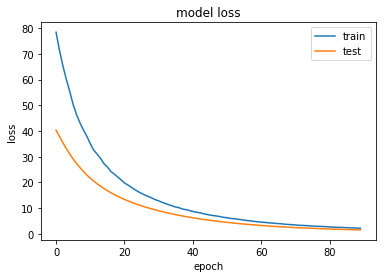

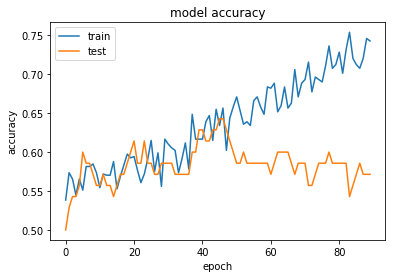

In [8]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

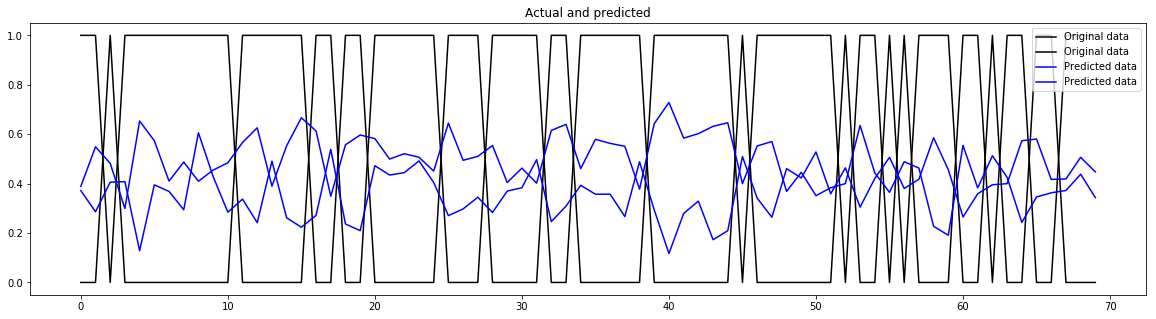

In [9]:
pred = model.predict(np.array(X_test)) 
original = Y_test 
predicted = pred  
plt.figure(figsize=(20, 5))
plt.plot(original, color='black', label = 'Original data') 
plt.plot(predicted, color='blue', label = 'Predicted data') 
plt.legend(loc='best') 
plt.title('Actual and predicted') 
plt.show()